In [36]:
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub

# model building
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

# split data into train and test set
from sklearn.model_selection import train_test_split

# plot lib
import matplotlib.pyplot as plt

# score handling
from sklearn.metrics import confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings("ignore")

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/AT&T_Spam_Detector/spam.csv',encoding='ISO-8859-1')
display (df.head())
print (df.shape)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


(5572, 5)


In [39]:
# Remplacer les valeurs NaN par des chaînes vides
df['Unnamed: 2'].fillna('', inplace=True)
df['Unnamed: 3'].fillna('', inplace=True)
df['Unnamed: 4'].fillna('', inplace=True)

# Concaténer les colonnes à 'v2'
df['v2'] = df['v2'] + df['Unnamed: 2'] + df['Unnamed: 3'] + df['Unnamed: 4']

# Supprimer les colonnes inutiles
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)

df = df.rename(columns={"v1":"label", "v2":"sms_content"})
df['label'] = df['label'].map( {'spam': 1, 'ham': 0} )

# Afficher les premières lignes du dataframe modifié
df.head()

,label,sms_content
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [40]:
X = df['sms_content']
y = df['label']

In [41]:
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.15)

In [42]:
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val = tf.data.Dataset.from_tensor_slices((X_val, y_val))

In [43]:
# Récupération du prochain lot de données (batch) de la taille de 5 à partir du Dataset 'train'
train_examples_batch, train_labels_batch = next(iter(train.batch(5)))

# Affichage des exemples de données du lot récupéré
print(train_examples_batch)

tf.Tensor(
[b'You have won a guaranteed \xc3\xa5\xc2\xa3200 award or even \xc3\xa5\xc2\xa31000 cashto claim UR award call free on 08000407165 (18+) 2 stop getstop on 88222 PHP'
 b"I can. But it will tell quite long, cos i haven't finish my film yet..."
 b'Can you open the door?'
 b'Ffffffffff. Alright no way I can meet up with you sooner?'
 b"I'm so in love with you. I'm excited each day i spend with you. You make me so happy."], shape=(5,), dtype=string)


In [44]:
train_labels_batch

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([1, 0, 0, 0, 0])>

In [45]:
# URL de l'incorporation pré-entraînée (embedding) de TensorFlow Hub
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"

# Création d'une couche Keras utilisant l'incorporation pré-entraînée
hub_layer = hub.KerasLayer(
    embedding,         # URL de l'incorporation pré-entraînée
    input_shape=[],    # La couche accepte des entrées de forme arbitraire (scalaires dans ce cas)
    dtype=tf.string,   # Le type de données des entrées est une chaîne de caractères (string)
    trainable=True     # Permettre l'entraînement de la couche (mise à jour des poids pendant l'entraînement)
)

In [46]:
from keras.layers import LSTM
# RNN semble être intégré dans la couche Hub
# De plus, la sortie de la couche Hub n'est pas séquentielle
# Dans ce contexte, j'utiliserai des calques denses.

model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 50)                48190600  
                                                                 
 dense_6 (Dense)             (None, 32)                1632      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 16)                528       
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48192777 (183.84 MB)
Trainable params: 48192777 (183.84 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [47]:
# Compilation du modèle
model.compile(
    optimizer='adam',  # Utilisation de l'optimiseur Adam pour mettre à jour les poids du modèle pendant l'entraînement
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),  # Utilisation de la fonction de perte d'entropie binaire croisée
                                                                # Spécifie 'from_logits=True' si la sortie du modèle n'est pas normalisée
    metrics=['accuracy']  # Utilisation de l'exactitude comme métrique pour évaluer la performance du modèle
)

In [48]:
# Entraînement du modèle avec les données d'entraînement et de validation
history = model.fit(
    train.shuffle(10000).batch(512),  # Mélange les données d'entraînement et les divise en lots de 512 exemples
    epochs=15,                        # Nombre d'époques d'entraînement
    validation_data=val.batch(512),   # Divise les données de validation en lots de 512 exemples
    verbose=1                         # Affiche la progression de l'entraînement
)


Epoch 1/15
10/10 [==============================] - 16s 1s/step - loss: 0.6886 - accuracy: 0.5697 - val_loss: 0.6239 - val_accuracy: 0.8684
Epoch 2/15
10/10 [==============================] - 15s 1s/step - loss: 0.5930 - accuracy: 0.8592 - val_loss: 0.5463 - val_accuracy: 0.8780
Epoch 3/15
10/10 [==============================] - 14s 1s/step - loss: 0.5142 - accuracy: 0.8689 - val_loss: 0.4638 - val_accuracy: 0.8768
Epoch 4/15
10/10 [==============================] - 15s 1s/step - loss: 0.4301 - accuracy: 0.8706 - val_loss: 0.3806 - val_accuracy: 0.8816
Epoch 5/15
10/10 [==============================] - 16s 2s/step - loss: 0.3486 - accuracy: 0.8792 - val_loss: 0.3075 - val_accuracy: 0.8923
Epoch 6/15
10/10 [==============================] - 17s 2s/step - loss: 0.2791 - accuracy: 0.8942 - val_loss: 0.2475 - val_accuracy: 0.9103
Epoch 7/15
10/10 [==============================] - 14s 1s/step - loss: 0.2226 - accuracy: 0.9286 - val_loss: 0.1968 - val_accuracy: 0.9426
Epoch 8/15
10/10 [==

In [49]:
# Évaluation du modèle sur le Dataset de validation, avec des lots (batches) de taille 512
# verbose=2 permet d'afficher un résumé de chaque batch lors de l'évaluation
results = model.evaluate(val.batch(512), verbose=2)

# Affichage des noms des métriques et des résultats associés
for name, value in zip(model.metrics_names, results):
    print("%s: %.3f" % (name, value))

2/2 - 0s - loss: 0.0441 - accuracy: 0.9844 - 363ms/epoch - 181ms/step
loss: 0.044
accuracy: 0.984


In [50]:
# Prédiction des classes pour les données d'entraînement
y_pred_train = (model.predict(X_train) > 0.5).astype("int32")
# Prédiction des classes pour les données de validation
y_pred_val = (model.predict(X_val) > 0.5).astype("int32")

27/27 [==============================] - 5s 183ms/step


In [51]:
print(f"accuracy score on train set : {accuracy_score(y_train, y_pred_train)}")
print(f"accuracy score on validation set : {accuracy_score(y_val, y_pred_val)}")

accuracy score on train set : 0.995777027027027
accuracy score on validation set : 0.9844497607655502


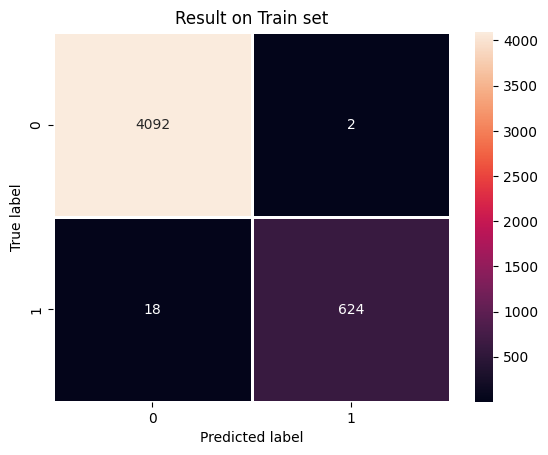

In [52]:
# Création de la matrice de confusion sur le train set
mtx = confusion_matrix(y_train, y_pred_train)
sns.heatmap(mtx, annot=True, fmt='d', linewidths=.8)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Result on Train set')
plt.show()

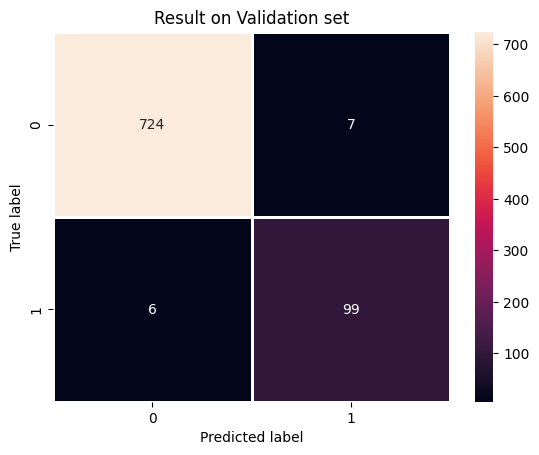

In [53]:
# Création de la matrice de confusion sur le validation set
mtx = confusion_matrix(y_val, y_pred_val)
sns.heatmap(mtx, annot=True, fmt='d', linewidths=.8)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Result on Validation set')
plt.show()

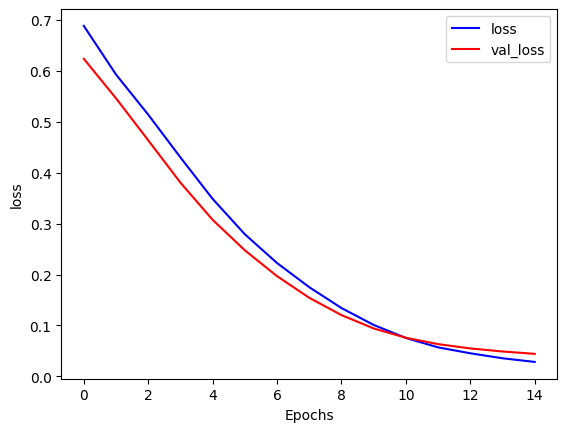

In [54]:
# Tracer la courbe de l'erreur de l'entraînement
plt.plot(history.history["loss"], color="b", label='loss')
# Tracer la courbe de l'erreur de la validation
plt.plot(history.history["val_loss"], color="r", label='val_loss')
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.legend(loc="upper right")
plt.show()

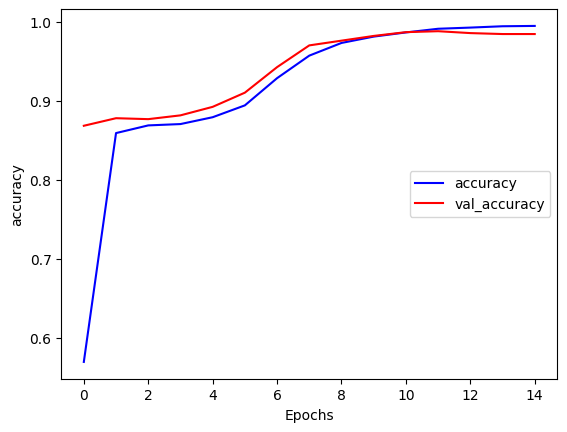

In [55]:
# Tracer la courbe de l'accuracy de l'entraînement
plt.plot(history.history["accuracy"], color="b", label='accuracy')
# Tracer la courbe de l'accuracy de la validation
plt.plot(history.history["val_accuracy"], color="r", label='val_accuracy')
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.legend(loc="right")
plt.show()